## Description:
这里用Pytorch搭建NFM Model在cretio数据集上进行点击率预测的任务

In [4]:
"""导入包"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

# pytorch
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from torchkeras import summary, Model
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

## 数据准备

In [5]:
file_path = './preprocessed_data/'

In [6]:
def prepared_data(file_path):
    # 读入训练集， 验证集和测试集
    train = pd.read_csv(file_path + 'train_set.csv')
    val = pd.read_csv(file_path + 'val_set.csv')
    test = pd.read_csv(file_path + 'test_set.csv')
    
    trn_x, trn_y = train.drop(columns='Label').values, train['Label'].values
    val_x, val_y = val.drop(columns='Label').values, val['Label'].values
    test_x = test.values
    
    fea_col = np.load(file_path + 'fea_col.npy', allow_pickle=True)
    
    return fea_col, (trn_x, trn_y), (val_x, val_y), test_x

In [7]:
"""导入数据"""
fea_cols, (trn_x, trn_y), (val_x, val_y), test_x = prepared_data(file_path)

In [8]:
# 把数据构建成数据管道
dl_train_dataset = TensorDataset(torch.tensor(trn_x).float(), torch.tensor(trn_y).float())
dl_val_dataset = TensorDataset(torch.tensor(val_x).float(), torch.tensor(val_y).float())

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=32)
dl_val = DataLoader(dl_val_dataset, shuffle=True, batch_size=32)

In [9]:
# 看一眼数据
for x, y in iter(dl_train):
    print(x.shape, y)
    break

torch.Size([32, 39]) tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])


## 构建模型
这里依然是使用继承nn.Modult基类构建模型， 并辅助应用模型容器进行封装， NFM的模型架构如下：

![](https://img-blog.csdnimg.cn/20201226203533392.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3d1emhvbmdxaWFuZw==,size_1,color_FFFFFF,t_70#pic_center)

这个模型也是两部分， 下面是特征交叉池化层， 上面是DNN， 由于这个特征交叉池化层是将embedding层的特征向量进行了两两交叉，所以这里可以把这个融合到最终的NFM里面去， 所以下面只需要把DNN给构建好，就可以构建整体的NFM模型了。

In [10]:
class Dnn(nn.Module):
    def __init__(self, hidden_units, dropout=0.):
        """
        hidden_units: 列表， 每个元素表示每一层的神经单元个数， 比如[256, 128, 64], 两层网络， 第一层神经单元128， 第二层64， 第一个维度是输入维度
        dropout = 0.
        """
        super(Dnn, self).__init__()
        
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):  
        for linear in self.dnn_network:
            x = linear(x)
            x = F.relu(x)    
        x = self.dropout(x) 
        return x

In [11]:
class NFM(nn.Module):
    def __init__(self, feature_columns, hidden_units, dnn_dropout=0.):
        """
        NFM:
        :param feature_columns: 特征信息， 这个传入的是fea_cols
        :param hidden_units: 隐藏单元个数， 一个列表的形式， 列表的长度代表层数， 每个元素代表每一层神经元个数
        """
        super(NFM, self).__init__()
        self.dense_feature_cols, self.sparse_feature_cols = feature_columns
        
        # embedding
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(i): nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim'])
            for i, feat in enumerate(self.sparse_feature_cols)
        })
        
        # 这里要注意Pytorch的linear和tf的dense的不同之处， 前者的linear需要输入特征和输出特征维度， 而传入的hidden_units的第一个是第一层隐藏的神经单元个数，这里需要加个输入维度
        self.fea_num = len(self.dense_feature_cols) + self.sparse_feature_cols[0]['embed_dim']
        hidden_units.insert(0, self.fea_num)
        
        self.bn = nn.BatchNorm1d(self.fea_num)     
        self.dnn_network = Dnn(hidden_units, dnn_dropout)
        self.nn_final_linear = nn.Linear(hidden_units[-1], 1)
    
    def forward(self, x):
        dense_inputs, sparse_inputs = x[:, :len(self.dense_feature_cols)], x[:, len(self.dense_feature_cols):]
        sparse_inputs = sparse_inputs.long()       # 转成long类型才能作为nn.embedding的输入
        sparse_embeds = [self.embed_layers['embed_'+str(i)](sparse_inputs[:, i]) for i in range(sparse_inputs.shape[1])]
        sparse_embeds = torch.stack(sparse_embeds)     # embedding堆起来， (field_dim, None, embed_dim)
        sparse_embeds = sparse_embeds.permute((1, 0, 2))
        # 这里得到embedding向量之后 sparse_embeds(None, field_num, embed_dim), 进行特征交叉层，按照那个公式
        embed_cross = 1/2 * (
            torch.pow(torch.sum(sparse_embeds, dim=1),2) - torch.sum(torch.pow(sparse_embeds, 2), dim=1)
        )  # (None, embed_dim)
        
        # 把离散特征和连续特征进行拼接作为FM和DNN的输入
        x = torch.cat([embed_cross, dense_inputs], dim=-1)
        # BatchNormalization
        # fea_num = len(dense_feature_cols) + embed_dim
        x = self.bn(x)
        
        # deep
        dnn_outputs = self.nn_final_linear(self.dnn_network(x))
        outputs = F.sigmoid(dnn_outputs)
        
        return outputs

In [12]:
# 建立模型
hidden_units = [128, 64, 32]
dnn_dropout = 0.2

model = NFM(fea_cols, hidden_units, dnn_dropout)
print(model.embed_layers)

ModuleDict(
  (embed_0): Embedding(79, 8)
  (embed_1): Embedding(252, 8)
  (embed_2): Embedding(1293, 8)
  (embed_3): Embedding(1043, 8)
  (embed_4): Embedding(30, 8)
  (embed_5): Embedding(7, 8)
  (embed_6): Embedding(1164, 8)
  (embed_7): Embedding(39, 8)
  (embed_8): Embedding(2, 8)
  (embed_9): Embedding(908, 8)
  (embed_10): Embedding(926, 8)
  (embed_11): Embedding(1239, 8)
  (embed_12): Embedding(824, 8)
  (embed_13): Embedding(20, 8)
  (embed_14): Embedding(819, 8)
  (embed_15): Embedding(1159, 8)
  (embed_16): Embedding(9, 8)
  (embed_17): Embedding(534, 8)
  (embed_18): Embedding(201, 8)
  (embed_19): Embedding(4, 8)
  (embed_20): Embedding(1204, 8)
  (embed_21): Embedding(7, 8)
  (embed_22): Embedding(12, 8)
  (embed_23): Embedding(729, 8)
  (embed_24): Embedding(33, 8)
  (embed_25): Embedding(554, 8)
)


In [13]:
# summary(model, input_shape=(trn_x.shape[1],))

In [14]:
# 测试一下模型
for fea, label in iter(dl_train):
    out = model(fea)
    print(out)
    break

tensor([[0.5402],
        [0.5538],
        [0.5442],
        [0.5273],
        [0.5201],
        [0.5600],
        [0.5402],
        [0.5287],
        [0.5456],
        [0.5382],
        [0.5344],
        [0.5257],
        [0.5431],
        [0.5233],
        [0.5359],
        [0.5429],
        [0.5257],
        [0.5305],
        [0.5486],
        [0.5357],
        [0.5383],
        [0.5304],
        [0.5293],
        [0.5170],
        [0.5391],
        [0.5285],
        [0.5336],
        [0.5284],
        [0.5309],
        [0.5555],
        [0.5566],
        [0.5431]], grad_fn=<SigmoidBackward>)


## 模型的训练

In [15]:
# 模型的相关配置
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)

loss_func = nn.BCELoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
metric_func = auc
metric_name = 'auc'

In [16]:
# 脚本训练风格
epochs = 10
log_step_freq = 10

dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])

print('start_training.........')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========'*8 + '%s' %nowtime)

for epoch in range(1, epochs+1):
    
    # 训练阶段
    model.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions = model(features)
        predictions = predictions.squeeze(-1)  #统一label和predictions 的数据维度
        loss = loss_func(predictions, labels)
        try:
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step=%d] loss: %.3f, " + metric_name + ": %.3f") % (step, loss_sum/step, metric_sum/step));
    
    # 验证阶段
    model.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(dl_val, 1):
        with torch.no_grad():
            predictions = model(features)
            predictions = predictions.squeeze(-1)  #统一label和predictions 的数据维度
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印日志
    print(("\nEPOCH=%d, loss=%.3f, " + metric_name + " = %.3f, val_loss=%.3f, " + "val_" + metric_name + " = %.3f") %info)
    nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('\n' + '=========='* 8 + '%s' %nowtime)
    
print('Finished Training')

start_training.........
================================================================2022-10-17 19:28:22
[step=10] loss: 0.698, auc: 0.480
[step=20] loss: 0.667, auc: 0.495
[step=30] loss: 0.628, auc: 0.496
[step=40] loss: 0.606, auc: 0.507

EPOCH=1, loss=0.606, auc = 0.507, val_loss=0.465, val_auc = 0.580

================================================================================2022-10-17 19:28:23
[step=10] loss: 0.491, auc: 0.647
[step=20] loss: 0.493, auc: 0.614
[step=30] loss: 0.495, auc: 0.612
[step=40] loss: 0.506, auc: 0.634

EPOCH=2, loss=0.506, auc = 0.634, val_loss=0.441, val_auc = 0.640

================================================================================2022-10-17 19:28:23
[step=10] loss: 0.497, auc: 0.676
[step=20] loss: 0.492, auc: 0.702
[step=30] loss: 0.499, auc: 0.682
[step=40] loss: 0.494, auc: 0.679

EPOCH=3, loss=0.494, auc = 0.679, val_loss=0.435, val_auc = 0.637

================================================================================

In [17]:
dfhistory

,epoch,loss,auc,val_loss,val_auc
0,1.0,0.605825,0.506558,0.465242,0.579613
1,2.0,0.505612,0.633866,0.441206,0.639869
2,3.0,0.493781,0.679399,0.434656,0.636930
3,4.0,0.479276,0.709748,0.430714,0.658242
4,5.0,0.474783,0.722035,0.454435,0.612710
5,6.0,0.466744,0.734874,0.438772,0.655977
6,7.0,0.447885,0.781591,0.448693,0.601081
7,8.0,0.434932,0.777200,0.448063,0.639589
8,9.0,0.409372,0.826305,0.482474,0.614154
9,10.0,0.385220,0.852128,0.481009,0.586978


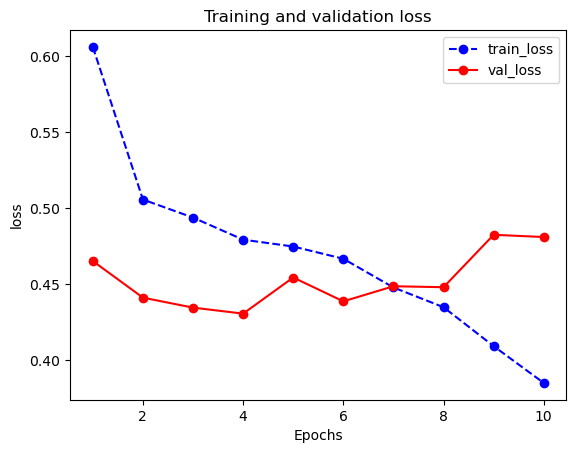

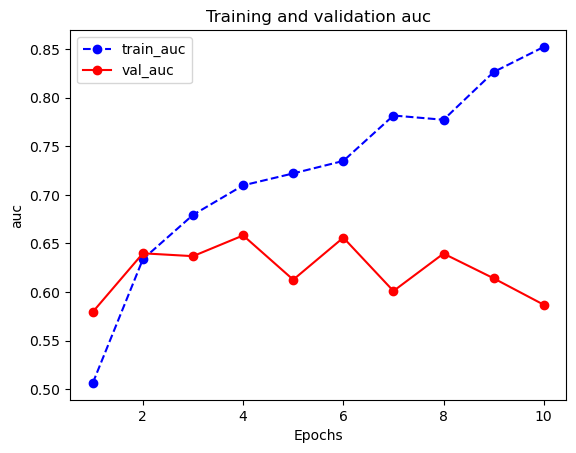

In [18]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")

In [19]:
# 预测
y_pred_probs = model(torch.tensor(test_x).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [21]:
y_pred.int()

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],

In [22]:
# 模型的保存与使用
torch.save(model, './model/NFM.pkl')

In [23]:
net_clone = torch.load('./model/NFM.pkl')

In [24]:
y_pred_probs = model(torch.tensor(test_x).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [25]:
y_pred

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      